In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from cardinality_estimation.featurizer import Featurizer
from query_representation.query import load_qrep
from cardinality_estimation.dataset import *
from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt

In [4]:
def get_attr_vecs(curx, curattrs):
    #idxs = 0
    xsum = curx.sum(axis=0).sum(axis=0)
    zero_idxs = xsum == 0
    curattrs = curattrs[:,:,~zero_idxs]
    idxs = np.array(range(len(xsum)))[~zero_idxs]
    
    #print(curx)
    #print(zero_idxs)
    #print(idxs)
    
    curx = curx[:,:,~zero_idxs]
    
    assert curx.shape == curattrs.shape
    
    # TODO: avg based on non-zero elements
    
    #print("attr sum: ", np.sum(curattrs))
    curattrs = np.abs(curattrs)
    #print("attr sum after abs: ", np.sum(curattrs))
    
    attr_sum = curattrs.sum(axis=0).sum(axis=0)
    
    assert attr_sum.shape[0] == curx.shape[-1]
    
    # TODO: do we need this?
    #attr_sum = attr_sum / np.linalg.norm(attr_sum, ord=1)
    
    # TODO: do this or no?
    curx_nonz = curx != 0
    
    xnonzero_sums = curx_nonz.sum(axis=0).sum(axis=0)
    
    #TODO?
    attr_sum = attr_sum / xnonzero_sums
    
    return idxs, attr_sum

def get_mscn_attrs(xbatch, attrs, featurizer, normalize=True):
    '''
    returns a vector with x-axis names and attribution values;
    '''
    batchsize = xbatch["table"].shape[0]
    assert batchsize == attrs[0].shape[0]
    tabidxs, tabattrs = get_attr_vecs(xbatch["table"].detach().numpy(), attrs[0].detach().numpy())
    predidxs, predattrs = get_attr_vecs(xbatch["pred"].detach().numpy(), attrs[1].detach().numpy())
    print(predidxs)
    joinidxs, joinattrs = get_attr_vecs(xbatch["join"].detach().numpy(), attrs[2].detach().numpy())
    
    # TODO: need to do sample_bitmaps
    tablabels = []
    for curtabidx in tabidxs:
        for tab,tidx in featurizer.table_featurizer.items():
            if tidx == curtabidx:
                tablabels.append(tab)
                break
    joinlabels = []
    for curjidx in joinidxs:
        for join,jidx in featurizer.join_featurizer.items():
            found = False
            if curjidx == jidx:
                joinlabels.append(join)
                found = True
                break
        if not found:
            joinlabels.append("unknown")
    # TODO: join-stats
    
    predlabels = []
    colstart,collen = featurizer.featurizer_type_idxs["col_onehot"]
    # TODO: if stats used
    #colstatsstart,colstatsend = self.featurizer_type_idxs["col_stats"]
    cmp_start,cmplen = featurizer.featurizer_type_idxs["cmp_op"]
    cstart,clen = featurizer.featurizer_type_idxs["constant_continuous"]
    lstart,llen = featurizer.featurizer_type_idxs["constant_like"]
    dstart,dlen = featurizer.featurizer_type_idxs["constant_discrete"]
    hstart,hlen = featurizer.featurizer_type_idxs["heuristic_ests"]
    
    #print(hstart, hlen)
    for pi in predidxs:
        if pi >= colstart and pi < colstart+collen:
            found = False
            for col,colidx in featurizer.columns_onehot_idx.items():
                if colidx == pi-colstart:
                #if colidx == pi:
                    print(col)
                    predlabels.append(col)
                    found = True
                    break     
            if not found:
                print(pi)
                predlabels.append("col-unknown")
        elif pi >= cmp_start and pi < cmp_start+cmplen:
            predlabels.append("cmp")
        elif pi == cstart:
            #predlabels.append("<")
            predlabels.append("range-filter")
        elif pi == cstart+1:
            predlabels.append("range-filter")
        elif pi >= lstart and pi < lstart+llen:
            #predlabels.append("Like-Hash-" + str(pi))
            predlabels.append("Like-Hashes")
        elif pi >= dstart and pi < dstart+dlen:
            #predlabels.append("Constant-Hash-" + str(pi))
            predlabels.append("Constant-Hashes")
        elif pi == hstart:
            predlabels.append("PostgreSQL Est (Table)")
        elif pi == hstart+1:
            predlabels.append("PostgreSQL Est (Subplan)")
    
    assert len(predidxs) == len(predlabels)
#     print(len(predidxs), len(predlabels))
#     print(predidxs)
#     print(predlabels)
    attrs = np.concatenate([tabattrs, joinattrs, predattrs])
    xlabels = tablabels + joinlabels + predlabels
    
    if normalize:
        attrs = attrs / np.linalg.norm(attrs, ord=1)
    
    return xlabels,attrs

In [5]:
from cardinality_estimation.nets import *

def get_model_attrs(mscn_model, weights, xbatch):
    n_out = 1
    sfeats = mscn_model.sample_mlp1.in_features
    pfeats = mscn_model.predicate_mlp1.in_features
    jfeats = mscn_model.join_mlp1.in_features

    net = SetConvNoFlow(sfeats,
        pfeats, jfeats,
        128,
        n_out=n_out,
        dropouts=[0.0, 0.0, 0.0])
    #print(net)
    #print(mscn_model)
    net.load_state_dict(weights)
    
    model = net
    model.eval()
    ig = IntegratedGradients(model)
    ig_nt = NoiseTunnel(ig)
    dl = DeepLift(model)
    gs = GradientShap(model)
    fa = FeatureAblation(model)
    limea = Lime(model)
    
    ig_attr_test = ig.attribute(tuple([xbatch["table"], xbatch["pred"],
                            xbatch["join"], 
                            xbatch["tmask"], xbatch["pmask"], 
                                   xbatch["jmask"]]), n_steps=50)
    #print("ig done")
    
    xlabels, igattrs = get_mscn_attrs(xbatch, ig_attr_test, featurizer, normalize=False)
    #xlabels, fattrs = get_mscn_attrs(xbatch, fa_attr_test, featurizer, normalize=False)
    #print(xlabels, igattrs)
    return xlabels, igattrs

In [8]:
import seaborn as sns

def plot_attrs(xlabels, attrs, ax=None):
    if ax is None:
        plt.figure(figsize=(20, 20))
        ax = plt.axes()

    #plt.yticks(fontsize=20)
    sns.barplot(x=attrs, y=xlabels, color='#4260f5', orient="horizontal", ax=ax, ci=None)

In [9]:
# import pickle

# if onehot_dropout:
#     with open("dropout-attrs.pkl", "wb") as f:
#         pickle.dump([xlabels, attrs], f)
# else:
#     with open("default-attrs.pkl", "wb") as f:
#         pickle.dump([xlabels, attrs], f)

In [10]:
with open("dropout-attrs.pkl", "rb") as f:
    xlabels,attrs = pickle.load(f)

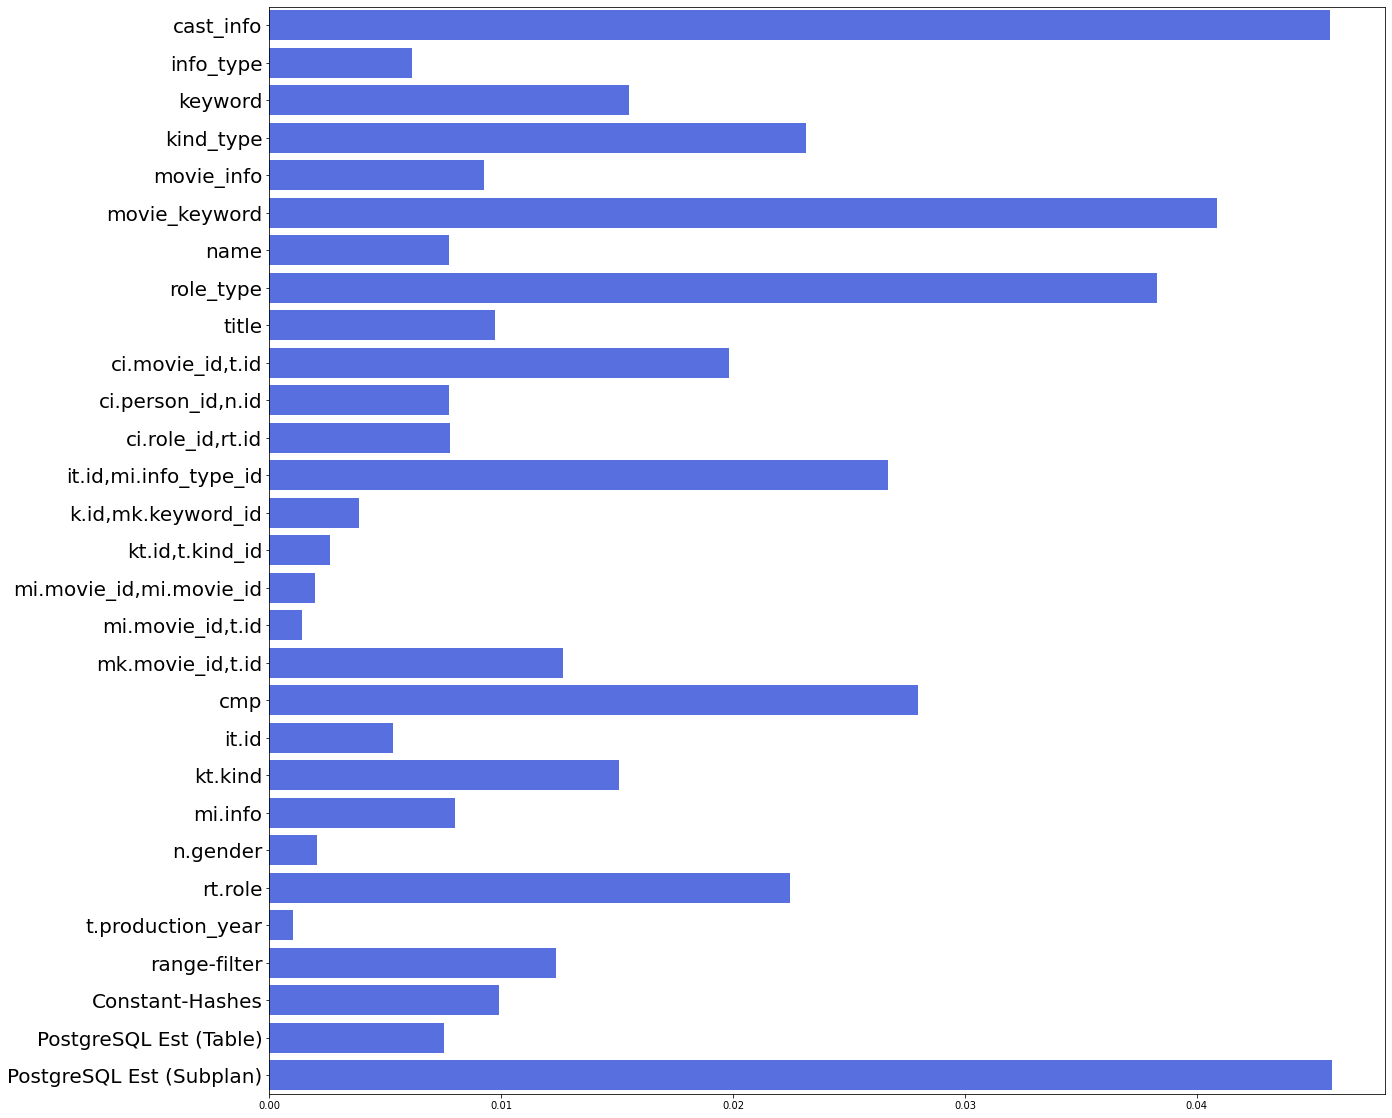

In [11]:
plot_attrs(xlabels, attrs)
plt.yticks(fontsize=20)
#plt.show()
plt.savefig("attribution-dropout.png")

In [12]:
attrs

array([0.04573258, 0.00613535, 0.0154923 , 0.02315028, 0.00925651,
       0.04086768, 0.00776261, 0.03825924, 0.00972575, 0.01982297,
       0.00776277, 0.00780823, 0.02666397, 0.00384812, 0.00261557,
       0.00194775, 0.00140194, 0.01264993, 0.04065232, 0.01530962,
       0.00532891, 0.01507626, 0.00798443, 0.00203494, 0.02247305,
       0.00100408, 0.00747163, 0.01723794, 0.00179428, 0.00574398,
       0.00219632, 0.00092361, 0.02720743, 0.01770548, 0.01540581,
       0.00820465, 0.00750992, 0.04584195])

In [23]:
featurizer.featurizer_type_idxs

{'join_onehot': (0, 9),
 'cmp_op': (0, 2),
 'col_onehot': (2, 18),
 'constant_continuous': (20, 2),
 'constant_like': (22, 12),
 'constant_discrete': (34, 10),
 'heuristic_ests': (44, 2)}

In [107]:
print(xbatch["table"].sum(axis=[0,1]))
print(xbatch["pred"].sum(axis=[0,1]))
print(xbatch["join"].sum(axis=[0,1]))

print(xbatch["table"].shape)
print(xbatch["pred"].shape)
print(xbatch["join"].shape)

tensor([220., 188.,  92., 136., 372., 182., 111., 111., 270.])
tensor([1010.0000,  540.0000,    0.0000,    0.0000,    0.0000,    0.0000,
         188.0000,   92.0000,  136.0000,  372.0000,    0.0000,  111.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,  111.0000,
         540.0000,    0.0000,    0.0000,  524.4604,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,  203.0000,    0.0000,
         186.0000,  186.0000,  322.0000,  203.0000,  230.0000,    0.0000,
         414.0000,  389.0000,  658.0579,  540.9561])
tensor([216., 110., 110., 186.,  91., 135., 124., 360., 180.])
torch.Size([290, 11, 9])
torch.Size([290, 11, 46])
torch.Size([290, 11, 9])
